In [1]:
import os
import numpy as np
import pandas as pd
import librosa, librosa.display
from util import *

from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Data Extraction

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("./data/audio_features_3_sec.csv")
print("Date shape: {}".format(df.shape))
df.head(5)

Date shape: (9685, 58)


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,pop.00027.0.wav,66150,0.354070,0.092004,0.133745,0.002745,3041.383942,7.140194e+05,3126.119651,180625.664149,...,75.57889,-1.411003,99.614210,-0.176044,120.819330,-0.039866,78.574684,-3.026498,86.39399,pop
1,pop.00027.1.wav,66150,0.346957,0.089579,0.143777,0.001806,2922.334626,1.250350e+06,2960.381766,225852.280494,...,75.58028,-6.210502,64.975590,-2.355854,87.215120,0.570278,94.365520,3.037296,105.46779,pop
2,pop.00027.2.wav,66150,0.328392,0.090207,0.130174,0.002610,2802.174545,7.740314e+05,3067.712826,229109.502454,...,76.66625,-1.685729,116.244995,-0.341337,114.137760,-0.482767,104.127144,-3.239160,106.19654,pop
3,pop.00027.3.wav,66150,0.310396,0.079919,0.171010,0.002549,2723.966562,9.677586e+05,2968.551682,172274.167333,...,159.05185,-1.928844,140.865980,-3.151660,95.238190,-8.257116,86.091090,-8.010163,141.83983,pop
4,pop.00027.4.wav,66150,0.440510,0.085436,0.148661,0.002220,2377.343178,8.584688e+05,2897.081914,198226.454488,...,32.92679,-1.269860,46.452496,-0.986701,28.281462,-3.069594,39.764366,-8.417820,50.49454,pop


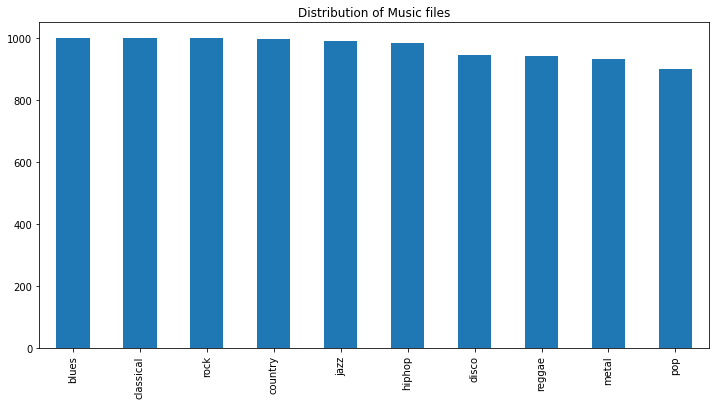

In [3]:
graph = df["label"].value_counts()
graph.plot.bar(x=graph.keys(), 
               y=graph.values, 
               title="Distribution of Music files",
               figsize=(12,6));

plt.show(block=True);

## Data Preparation

Preprocessing of data is required before we finally train the data. We will try and focus on the last column that is ‘label’ and will encode it with the function LabelEncoder() of sklearn.preprocessing.

In [4]:
from sklearn.preprocessing import LabelEncoder

class_list = df.iloc[:,-1]
converter = LabelEncoder()
y = converter.fit_transform(class_list)
y.shape

(9685,)

In [5]:
import pickle

mapping = dict(zip(converter.transform(converter.classes_), converter.classes_))
print(mapping)

f = open("mapping.pkl","wb")
pickle.dump(mapping,f)
f.close()

{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


## Data scaling

The data is scaled by using the StandardScaler from sklearn to standardize the features by removing the mean and scaling to unit variance. Once the StandardScaler is fitted to the dataset, the StandardScaler is persisted into a .bin using the joblib.dump function.

In [6]:
from sklearn.preprocessing import StandardScaler
from joblib import dump

scaler = StandardScaler()
df = df.drop(labels=["filename", "label"],axis=1)
X = scaler.fit_transform(df)
dump(scaler, 'standardscaler.bin', compress=True)

['standardscaler.bin']

## Dividing Training and Testing Dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 41, test_size = 0.20)
print("Train data size: {}, Validation data size: {}".format(len(y_train), len(y_test)))

Train data size: 7748, Validation data size: 1937


## Building the model


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [9]:
model = Sequential()
model.add(Dense(1024, input_shape=(X_train.shape[1],), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              58368     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

2022-05-31 19:02:15.038926: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model Training

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

batch_size=128
epochs = 600
model_weight = './model/best_weights.hdf5'

best_checkpoint = ModelCheckpoint(model_weight,
                                  save_weights_only=False, 
                                  save_best_only=True,
                                  monitor='val_accuracy',
                                  mode='max',
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_accuracy', 
                           patience=3, 
                           restore_best_weights=True, 
                           mode='max')

history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test,y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[best_checkpoint, early_stop],
                    verbose=1)

Epoch 1/600
58/61 [===========================>..] - ETA: 0s - loss: 1.5769 - accuracy: 0.4293
Epoch 00001: val_accuracy improved from -inf to 0.62416, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 1s 11ms/step - loss: 1.5635 - accuracy: 0.4352 - val_loss: 1.0832 - val_accuracy: 0.6242
Epoch 2/600
57/61 [===========================>..] - ETA: 0s - loss: 1.0368 - accuracy: 0.6453
Epoch 00002: val_accuracy improved from 0.62416 to 0.71864, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 0s 8ms/step - loss: 1.0357 - accuracy: 0.6467 - val_loss: 0.8308 - val_accuracy: 0.7186
Epoch 3/600
58/61 [===========================>..] - ETA: 0s - loss: 0.8510 - accuracy: 0.7134
Epoch 00003: val_accuracy improved from 0.71864 to 0.75116, saving model to ./model/best_weights.hdf5
61/61 [==============================] - 1s 8ms/step - loss: 0.8497 - accuracy: 0.7140 - val_loss: 0.7327 - val_accuracy: 0.7512
Epoch 4/600
57/61 [=====

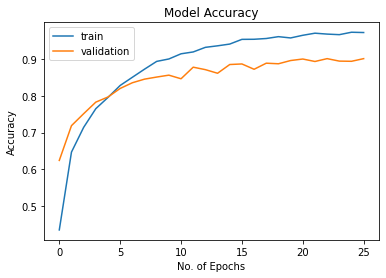

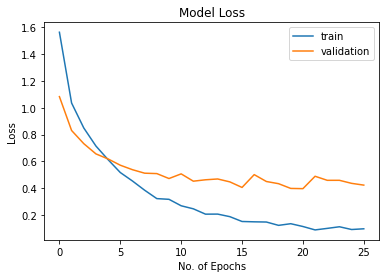

In [11]:
plot_training_graph(history)

# Model Evaluation

In [12]:
test_loss,test_acc = model.evaluate(X_test,y_test,batch_size=128)

print("The test loss is ",test_loss)
print("The best accuracy is: ",test_acc*100)

16/16 [==============================] - 0s 2ms/step - loss: 0.4591 - accuracy: 0.9009
The test loss is  0.4591345489025116
The best accuracy is:  90.08776545524597


# Make Prediction

In [13]:
from data_processing import *
from keras.models import load_model
from joblib import load
import pickle

/Users/christopher_sia/opt/anaconda3/envs/python37/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [14]:
model = load_model('./model/best_weights.hdf5')
print("Loading model... done")

label_mapping = pickle.load(open("mapping.pkl", "rb"))
print("Loading label mappings... done")

scaler = load('standardscaler.bin')
print("Loading standard scaler... done")

Loading model... done
Loading label mappings... done
Loading standard scaler... done


In [19]:
audio_file = "./data/metal/metal.00028.wav"
features = pd.DataFrame()
temp_dir = os.path.abspath("temp")

audio_chunks = extract_audio_chunks(audio_file, 3000, temp_dir)

for audio_chunk in audio_chunks:
    features = features.append(extract_features(audio_chunk), ignore_index=True)

clear_folder(temp_dir)

features = features.drop(labels=["filename", "label"],axis=1)
features = scaler.transform(features)
predictions = model.predict(features)

In [20]:
from collections import Counter

prediction = []

for pred in predictions:
    prediction.append(label_mapping[np.argmax(pred)])

prediction = Counter(prediction)
prediction = prediction.most_common()[0][0]
print(prediction)

metal
